Нужно построить модель отклика на предложение покупки полиса КАСКО – обучить логистическую регрессию, которая будет возвращать вероятность покупки.

Качество решения будет оцениваться по величине Gini (внимательнее к данным, имеет смысл их предварительно изучить) и общей аккуратности оформления. Модель должна быть валидирована и результаты валидации должны быть показаны в решении. Почему именно логистическая регрессия – 1) это наиболее простой алгоритм, 2) он позволит оценить логику решения, а не только технический навык.

# 1. Импорты и полезные функции

In [1]:
import numpy as np
import pandas as pd
import warnings

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Для оценки взаимодействия предикторов
from sklearn_gbmi import *
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score

#Оптимизация модели
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

#Options
random_state = 999
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
#Расчет показателя Gini  и AUC
def model_score(y_test, y_pred_prob, plot=True):
    gini = 2*roc_auc_score(y_test, y_pred_prob[:,1:])-1
    auc = roc_auc_score(y_test, y_pred_prob[:,1:])
    
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1:])
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.plot(fpr,tpr)

        ax.text(0.75, 0.04, "Gini: {0:.3} \nAUC: {1:.3}".format(gini, auc), fontsize=11)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.005])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title("ROC Curve")
    return gini, auc

Пара слов о том, что такое gini

<img src="https://alexanderdyakonov.files.wordpress.com/2015/12/gini1.png" align="left"/>


https://dyakonov.org/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/

In [3]:
def optimize_hyperparam(Model, init_params, space, X_, y_, n_eval=100):
    print(Model.__name__)

    def objective(space):        
        model = Model(**init_params, **space)    
        y_pred = cross_val_predict(model, X_, y_, cv=5, method="predict_proba")
        gini, auc = model_score(y_, y_pred, plot=False)
        return {'loss': -gini, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, 
                space=space, 
                trials=trials, 
                algo=tpe.suggest, 
                max_evals=n_eval, 
                rstate=np.random.RandomState(random_state),
                verbose=1)

    best_params = space_eval(space, best)
    print("Best params: {}".format(best_params))
    model = Model(**init_params, **best_params).fit(X_, y_)
    return model
    
    
#lr = optimize_hyperparam(LogisticRegression, lr_init_params, lr_space, X_train, y_train, n_eval=10)

# 2. Чтение данных

In [4]:
data = pd.read_excel("Test case - Regression.xlsx", header=1)
display(data.head(3))
display(data.info())

,Unnamed: 0,Gender,Age,Income,KASKO_flg
0,NaN,Female,49,30000,0
1,NaN,Male,38,135000,0
2,NaN,Male,41,70000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  0 non-null      float64
 1   Gender      40000 non-null  object 
 2   Age         40000 non-null  int64  
 3   Income      40000 non-null  int64  
 4   KASKO_flg   40000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.5+ MB


None

In [5]:
#Удалим лишний столбец
data.drop("Unnamed: 0", axis=1, inplace=True)

#Бинаризуем признак пола
map_Sex = {'Male': 1, 'Female':0}
data.replace({"Gender": map_Sex}, inplace=True)

display(data.head(3))

,Gender,Age,Income,KASKO_flg
0,0,49,30000,0
1,1,38,135000,0
2,1,41,70000,0


###  INFO

- Датасет получен и проверен на наличие отсутствующих признаков
- Удален ненужный столбец
- Признак пола бинаризирован. 



# 3. Изучение данных

In [6]:
display(data.describe())

,Gender,Age,Income,KASKO_flg
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.506525,40.046050,109766.500000,0.324425
std,0.499964,8.933391,51968.813212,0.468165
min,0.000000,25.000000,20000.000000,0.000000
25%,0.000000,32.000000,65000.000000,0.000000
50%,1.000000,40.000000,110000.000000,0.000000
75%,1.000000,48.000000,154000.000000,1.000000
max,1.000000,55.000000,200000.000000,1.000000


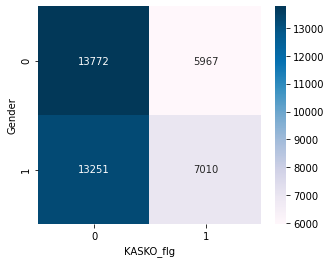

In [7]:
#Оценим распределение мужчин и женщин
fig, ax = plt.subplots(figsize=(5,4))
ct = pd.crosstab(data["Gender"], data["KASKO_flg"])
ax = sns.heatmap(ct, annot=True, fmt='g', cmap="PuBu", ax=ax)

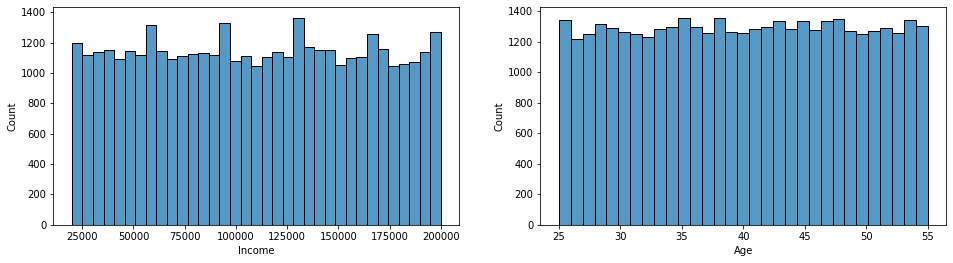

In [8]:
fig, ax = plt.subplots(figsize=(16,4), ncols=2)
ax[0] = sns.histplot(data["Income"], ax=ax[0])
ax[1] = sns.histplot(data["Age"], ax=ax[1], bins=31)

###  INFO

- В данных отсутствют экстремальные значения
- Признаки Age и Income имеют равномерное распределение
- Классы не сбалансированы


# 4. Базовая модель

In [9]:
X = data.drop(["KASKO_flg"], axis=1)
y = data['KASKO_flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state, shuffle=True)

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

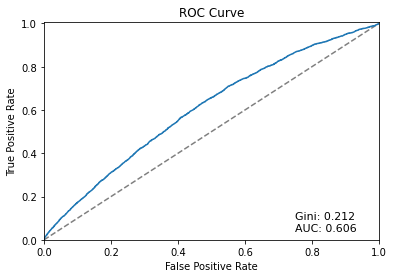

In [10]:
model_basic = LogisticRegression(random_state=random_state, class_weight="balanced")
model_basic = model_basic.fit(X_train, y_train)
y_pred = model_basic.predict_proba(X_test)

gini, auc = model_score(y_test, y_pred)

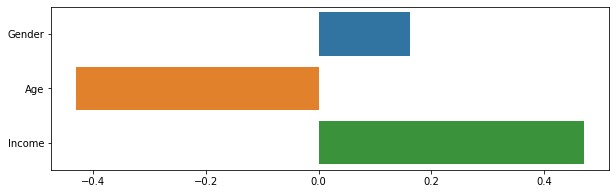

In [11]:
scores = model_basic.coef_[0]
fig, ax = plt.subplots(figsize=(10,3))
ax = sns.barplot(x=scores, y=X.columns, ax=ax) 

###  INFO 

- Значение gini составило 0.212 на тестовом наборе данных при обучении модели на трех предикторах.

# 5. Модель на сгенерированных признаках

Для поиска новых фичей применим 2 подхода - попробуем оценить предикторы более высокого порядка и посмотрим наличие влияния взаимодействующих предикторов.

Для генерации фичей применим PolynomialFeatures из пакета sklearn.preprocessing.

## Feature interactions
Предикторы с взаимодействием можно выявить несколькими способами
 - опираясь на априорные знания о предметной области
 - проверить взаимосвязь между значимыми предикторами
 - перебрать все возможные варианты и исключить малозначимые
 - рассчитать H-статистику Фридмана

Т.к. количество фичей небольшое и размер выборки позволяет - можем попробовать все возможные варианты. Но так же рассчитаем H-статистику для сравнения.

H-статистику рассчитаем при помощи метода h_all_pairs из пакета sklearn-gbmi. Значение H-статистики лежит в интервале от 0 до 1. Чем ближе значение к 1, тем сильнее эффект взаимодействия предикторов.

**Links**:
- https://blog.macuyiko.com/post/2019/discovering-interaction-effects-in-ensemble-models.html
- https://pypi.org/project/sklearn-gbmi/



In [12]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0).fit(X, y)
h_all_pairs(gbm, X, ["Gender", "Age", "Income"])

{('Gender', 'Age'): 0.8260674392691238,
 ('Gender', 'Income'): 0.08314175928852777,
 ('Age', 'Income'): 0.22708732887355076}

Судя по H-статистике, взаимосвязь наблюдается между предикторами Gender и Age.
Попробуем проверить этот тезис на практике.

## Генерация фичей

In [13]:
def rnm(x):
    d = {"x0": "Gender", "x1": "Age", "x2": "Income"}
    for k,v in d.items():
        x = x.replace(k, v)
    return x

X = data.drop(["KASKO_flg"], axis=1)
y = data['KASKO_flg']

poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

X_poly = pd.DataFrame(X_poly, columns=list(map(rnm, poly.get_feature_names())))

display(X_poly.head(3))

,Gender,Age,Income,Gender^2,Gender Age,Gender Income,Age^2,Age Income,Income^2
0,0.0,49.0,30000.0,0.0,0.0,0.0,2401.0,1470000.0,9.000000e+08
1,1.0,38.0,135000.0,1.0,38.0,135000.0,1444.0,5130000.0,1.822500e+10
2,1.0,41.0,70000.0,1.0,41.0,70000.0,1681.0,2870000.0,4.900000e+09


Признак Gender^2 является копией признакак Gender. Удалим его

In [14]:
X_poly = X_poly.drop(columns=["Gender^2"])

## Модель

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=random_state, shuffle=True)

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_poly.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_poly.columns)

print(X_train.columns)

Index(['Gender', 'Age', 'Income', 'Gender Age', 'Gender Income', 'Age^2',
       'Age Income', 'Income^2'],
      dtype='object')


LogisticRegression
100%|██████████| 10/10 [00:03<00:00,  2.85trial/s, best loss: -0.32253510478256375]
Best params: {'C': 0.1989760427392051}


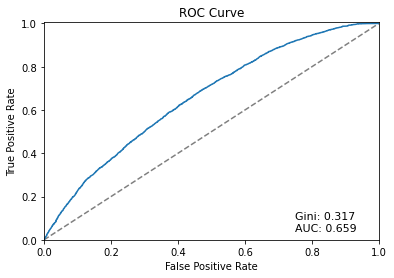

In [16]:
lr_init_params = {"class_weight":"balanced", 
                  "penalty": 'l1',
                  "solver": "saga",
                  "random_state":random_state}

lr_space = {
    'C': hp.uniform('C', 0,5)    
}

model_optimized = optimize_hyperparam(LogisticRegression, lr_init_params, lr_space, X_train, y_train, n_eval=10)
y_pred = model_optimized.predict_proba(X_test)
gini, auc = model_score(y_test, y_pred)

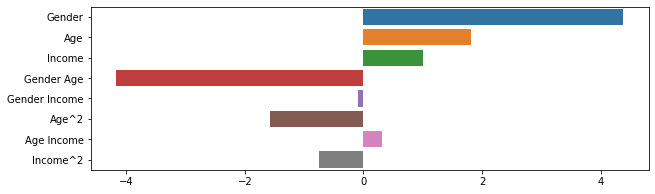

In [17]:
scores = model_optimized.coef_[0]
fig, ax = plt.subplots(figsize=(10,3))
ax = sns.barplot(x=scores, y=X_poly.columns, ax=ax) 

###  INFO 

- Значение gini удалось поднять до 0.317 на тестовом наборе данных
- Комбинация "Gender Age" оказалась значимой, второй по весу после признака "Gender". Остальные взаимодействия предикторов не оказыват существенного влияния на результат предсказания. Этот вывод совпадает с результатом расчета H-статистики для выявления feature interaction. 